In [1]:
import numpy as np

from matplotlib import pyplot as plt

import gpflow

import sys
sys.path.append('../')

from mfgpflow.data_loader import PowerSpecs
from mfgpflow.linear import MultiFidelityGPModel

def generate_data(folder: str = "data/50_LR_3_HR"):
    data = PowerSpecs()
    data.read_from_txt(folder=folder)
    return data

data = generate_data("../data/50_LR_3_HR")



Text(0, 0.5, '$P_{k}$')

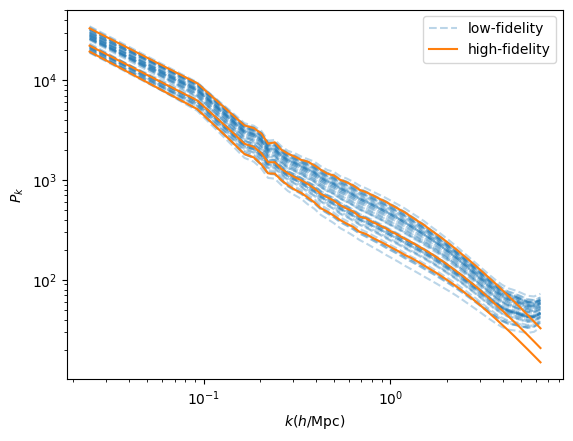

In [2]:
# visualize training spectra
for i,y_train in enumerate(data.Y_train[0]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="low-fidelity", color="C0", ls='--', alpha=0.3)
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C0", ls='--', alpha=0.3)
for i,y_train in enumerate(data.Y_train[1]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="high-fidelity", color="C1")
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C1")
plt.legend()
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k}$")


## SVGP for large-scale training

🔹 KMeans Inducing Points: [[0.78 0.63 0.2  0.64 0.11 0.  ]
 [0.17 0.33 0.81 0.23 0.69 0.  ]
 [0.25 0.61 0.57 0.93 0.81 0.  ]
 [0.77 0.29 0.51 0.19 0.43 0.  ]
 [0.55 0.65 0.83 0.79 0.65 0.  ]
 [0.29 0.51 0.87 0.83 0.47 1.  ]
 [0.79 0.17 0.35 0.85 0.63 0.  ]
 [0.11 0.95 0.17 0.71 0.45 0.  ]
 [0.09 0.63 0.01 0.21 0.09 0.  ]
 [0.53 0.09 0.11 0.39 0.79 1.  ]
 [0.21 0.89 0.65 0.03 0.25 1.  ]
 [0.65 0.71 0.09 0.69 0.91 0.  ]
 [0.45 0.49 0.71 0.41 0.29 0.  ]
 [0.13 0.39 0.69 0.91 0.35 0.  ]
 [0.71 0.55 0.91 0.53 0.37 0.  ]
 [0.53 0.09 0.11 0.39 0.79 0.  ]
 [0.99 0.05 0.89 0.37 0.13 0.  ]
 [0.61 0.15 0.43 0.99 0.11 0.  ]
 [0.03 0.21 0.55 0.07 0.23 0.  ]
 [0.43 0.86 0.6  0.61 0.42 0.  ]
 [0.87 0.77 0.47 0.33 0.93 0.  ]
 [0.05 0.97 0.33 0.29 0.49 0.  ]
 [0.31 0.93 0.37 0.89 0.77 0.  ]
 [0.21 0.89 0.65 0.03 0.25 0.  ]
 [0.33 0.59 0.99 0.45 0.85 0.  ]
 [0.91 0.35 0.79 0.73 0.83 0.  ]
 [0.89 0.47 0.03 0.95 0.03 0.  ]
 [0.59 0.01 0.39 0.09 0.61 0.  ]
 [0.85 0.75 0.63 0.49 0.21 0.  ]
 [0.19 0.19 0.45 

2025-02-17 21:07:37.195805: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


🔹 Iteration 0: ELBO = 5887.914118811825
🔹 Iteration 10: ELBO = 1919.7016527559283
🔹 Iteration 20: ELBO = 718.4309404752923
🔹 Iteration 30: ELBO = -564.4567278577749
🔹 Iteration 40: ELBO = -1804.3268620853323
🔹 Iteration 50: ELBO = -2828.8011715009015
🔹 Iteration 60: ELBO = -3851.865676539508
🔹 Iteration 70: ELBO = -4304.843578724136
🔹 Iteration 80: ELBO = -5013.420962708137
🔹 Iteration 90: ELBO = -4919.793000841576
🔹 Iteration 100: ELBO = -5311.004671482496
🔹 Iteration 110: ELBO = -5627.681056968713
🔹 Iteration 120: ELBO = -6027.818154745164
🔹 Iteration 130: ELBO = -5267.103032578034
🔹 Iteration 140: ELBO = -5145.275903582542
🔹 Iteration 150: ELBO = -5446.088376361371
🔹 Iteration 160: ELBO = -5904.752423996286
🔹 Iteration 170: ELBO = -6473.177114750846
🔹 Iteration 180: ELBO = -3326.7862899564316
🔹 Iteration 190: ELBO = -4073.9608845791086
🔹 Iteration 200: ELBO = -4460.387378211474
🔹 Iteration 210: ELBO = -4756.331730214524
🔹 Iteration 220: ELBO = -5142.46788468834
🔹 Iteration 230: ELBO

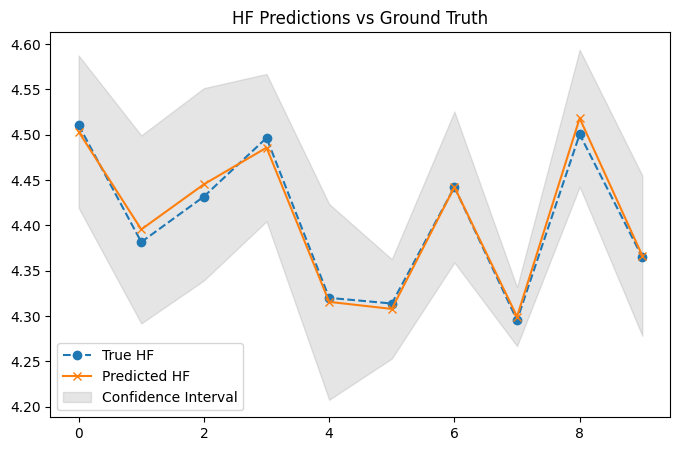

In [3]:
from mfgpflow.singlebin_svgp import SingleBinSVGP
import numpy as np
import gpflow
import tensorflow as tf
from sklearn.cluster import KMeans

# 🔹 1️⃣ Load Data
X_LF, Y_LF = data.X_train_norm[0], data.Y_train_norm[0]  # LF Data (50, 5) → (50, 49)
X_HF, Y_HF = data.X_train_norm[1], data.Y_train_norm[1]  # HF Data (3, 5) → (3, 49)
X_test_HF, Y_test_HF = data.X_test_norm[0], data.Y_test[0]  # Test HF Data (10, 5) → (10, 49)

# 🔹 2️⃣ Prepare Training Data
n_LF, n_HF = X_LF.shape[0], X_HF.shape[0]  # Number of points
output_dim = Y_LF.shape[1]  # 49 output dimensions
num_inducing = 50  # Reduce inducing points to prevent overfitting

# ✅ Append fidelity indicators (0 for LF, 1 for HF)
X_LF_aug = np.hstack([X_LF, np.zeros((n_LF, 1))])  # LF data with fidelity=0
X_HF_aug = np.hstack([X_HF, np.ones((n_HF, 1))])   # HF data with fidelity=1

# ✅ Combine datasets
X_train = np.vstack([X_LF_aug, X_HF_aug])  # Shape: (53, 6)
Y_train = np.vstack([Y_LF, Y_HF])  # Shape: (53, 49)

# 🔹 3️⃣ Define Multi-Fidelity GP Model
# ✅ Define base kernels for LF and HF discrepancy
kernel_L = gpflow.kernels.SquaredExponential(lengthscales=np.ones(5), variance=1.0)
kernel_delta = gpflow.kernels.SquaredExponential(lengthscales=np.ones(5), variance=1.0)

# ✅ Mixed Kernel (SE + Linear) to capture smooth & linear trends
kern_list = [gpflow.kernels.SquaredExponential() for _ in range(output_dim)]

# ✅ Optimize Inducing Points using K-Means Clustering
kmeans = KMeans(n_clusters=num_inducing, random_state=42).fit(X_train)
Z_init = kmeans.cluster_centers_

# ✅ Initialize the Latent Multi-Fidelity Coregionalization SVGP model
mf_gp = SingleBinSVGP(
    X_train, Y_train,
    kernel_L, kernel_delta,
    num_outputs=output_dim,
    Z=Z_init,
)

# 🔹 4️⃣ Train the Model with Adaptive Learning Rate
mf_gp.optimize(
    (X_train, Y_train),
    max_iters=2000,  # Reduce training iterations
    initial_lr=0.1,  # Lower learning rate for stability
    unfix_noise_after=500,  # Delay unfixing noise variance
    # decay_lr=True  # Enable learning rate decay
)

# 🔹 5️⃣ Make Predictions on HF Test Set
X_test_HF_aug = np.hstack([X_test_HF, np.ones((10, 1))])  # Add HF indicator (1)
mean_pred, var_pred = mf_gp.predict_f(X_test_HF_aug)

# 🔹 6️⃣ Compute Residuals
residuals = mean_pred.numpy() - Y_test_HF  # Shape: (10, 49)

# ✅ Print summary
print(f"🔍 Final Residuals: {residuals.mean():.4f} ± {residuals.std():.4f}")
print(f"✅ Model trained and predictions completed!")

# ✅ Check Noise Variance
print(f"🔍 Learned noise variance: {mf_gp.likelihood.variance.numpy()}")

# ✅ Evaluate Test Performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test_HF, mean_pred.numpy())
print(f"🔍 HF Prediction MSE: {mse:.4f}")

# ✅ Visualize Predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(Y_test_HF[:, 0], label="True HF", linestyle="--", marker="o")
plt.plot(mean_pred.numpy()[:, 0], label="Predicted HF", linestyle="-", marker="x")
plt.fill_between(
    np.arange(len(Y_test_HF[:, 0])),
    mean_pred.numpy()[:, 0] - 2 * np.sqrt(var_pred.numpy()[:, 0]),
    mean_pred.numpy()[:, 0] + 2 * np.sqrt(var_pred.numpy()[:, 0]),
    alpha=0.2, color="gray", label="Confidence Interval"
)
plt.legend()
plt.title("HF Predictions vs Ground Truth")
plt.show()

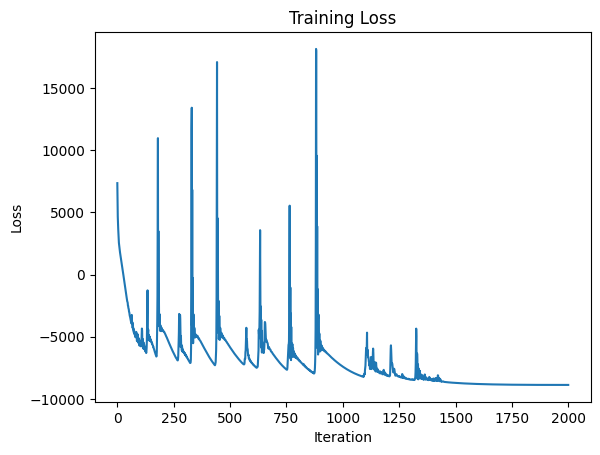

In [4]:
plt.plot(mf_gp.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

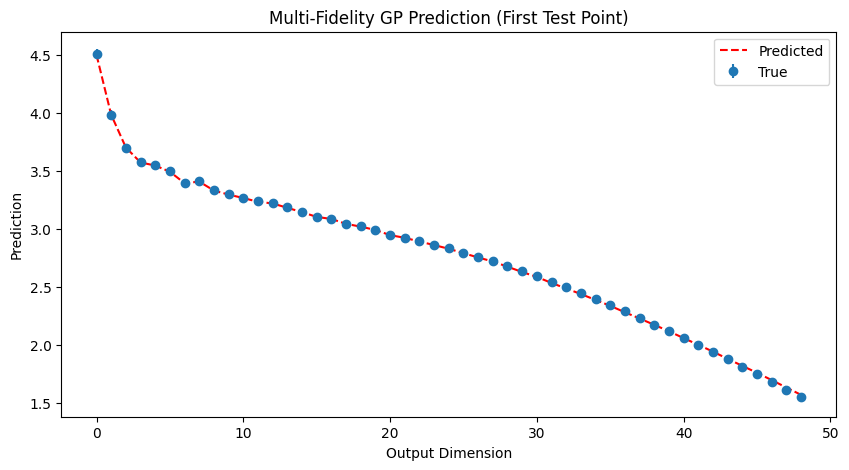

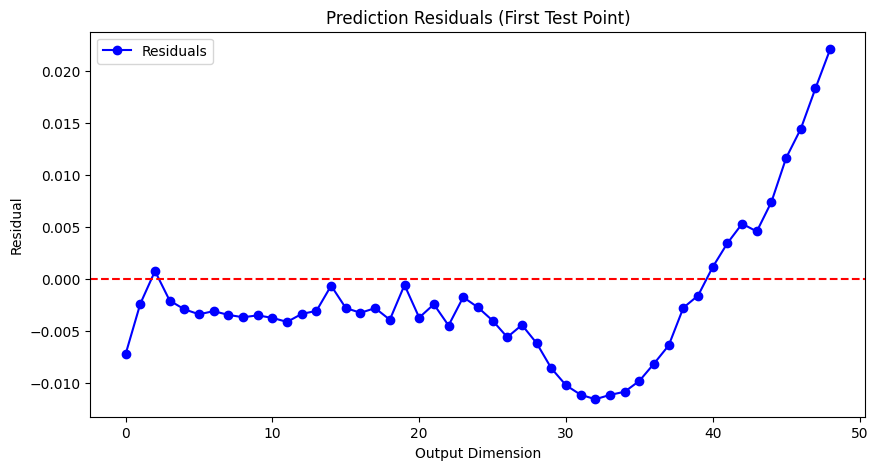

In [5]:

# 🔹 7️⃣ Plot Predictions vs Ground Truth
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(49), Y_test_HF[0], yerr=np.sqrt(var_pred.numpy()[0]), fmt='o', label="True")
plt.plot(np.arange(49), mean_pred.numpy()[0], 'r--', label="Predicted")
plt.xlabel("Output Dimension")
plt.ylabel("Prediction")
plt.legend()
plt.title("Multi-Fidelity GP Prediction (First Test Point)")
plt.show()

# 🔹 8️⃣ Residual Plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(49), residuals[0], 'bo-', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Output Dimension")
plt.ylabel("Residual")
plt.legend()
plt.title("Prediction Residuals (First Test Point)")
plt.show()

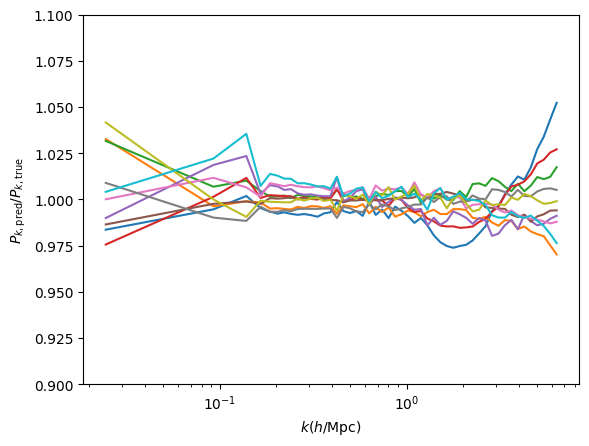

Text(0, 0.5, '$P_{k,\\mathrm{pred}}-P_{k,\\mathrm{true}}$')

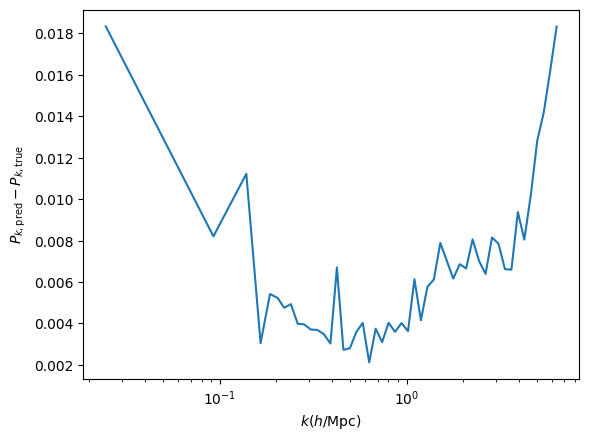

In [6]:
plt.semilogx(10**data.kf, (10**mean_pred/10**Y_test_HF).numpy().T);
plt.ylim(0.9, 1.1)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}/P_{k,\mathrm{true}}$")
plt.show()
# absolute error
plt.semilogx(10**data.kf, np.abs((10**mean_pred/10**Y_test_HF - 1).numpy()).mean(axis=0));
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}-P_{k,\mathrm{true}}$")

In [7]:
for var in mf_gp.trainable_variables:
    print(var.name, var.shape)

Variable:0 (50, 49)
fill_triangular:0 (49, 1275)
Variable:0 (50, 6)
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0 ()
softplus:0 (1, 1)
softplus:0 (5,)
softplus:0 ()
softplus:0 (5,)
softplus:0

In [8]:
mf_gp

name,class,transform,prior,trainable,shape,dtype,value
SingleBinSVGP.kernel.kernels[0].kernel_L.variance,Parameter,Softplus,,True,(),float64,0.0225
SingleBinSVGP.kernel.kernels[0].kernel_L.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[12.97331, 8.46531, 3.67968..."
SingleBinSVGP.kernel.kernels[0].kernel_delta.variance,Parameter,Softplus,,True,(),float64,2.48002
SingleBinSVGP.kernel.kernels[0].kernel_delta.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[21.27902, 22.38209, 11.00444..."
SingleBinSVGP.kernel.kernels[0].rho,Parameter,Softplus,,True,"(1, 1)",float64,[[1.53406]]
SingleBinSVGP.kernel.kernels[1].kernel_L.variance,Parameter,Softplus,,True,(),float64,0.03609
SingleBinSVGP.kernel.kernels[1].kernel_L.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[4.21901, 7.4986, 3.16979..."
SingleBinSVGP.kernel.kernels[1].kernel_delta.variance,Parameter,Softplus,,True,(),float64,2.22681
SingleBinSVGP.kernel.kernels[1].kernel_delta.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[21.90415, 25.8155, 10.85395..."
SingleBinSVGP.kernel.kernels[1].rho,Parameter,Softplus,,True,"(1, 1)",float64,[[1.29124]]


## Visualize the rho

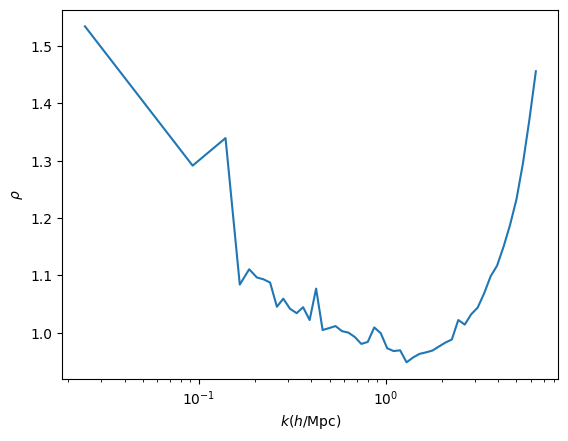

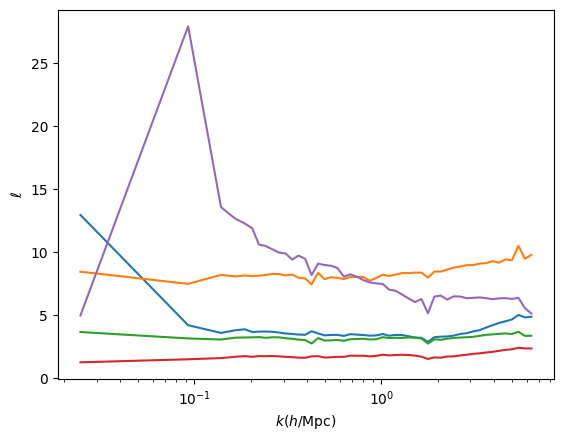

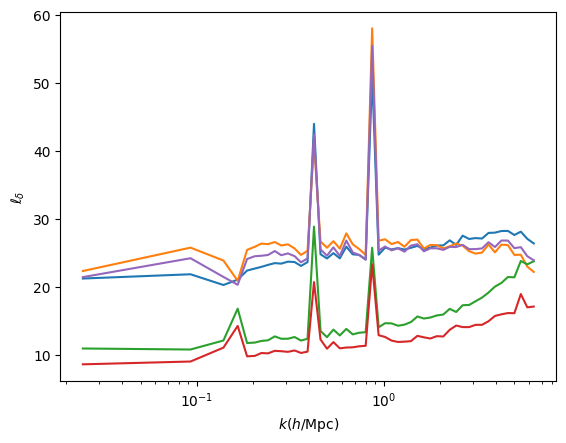

In [9]:
num_outputs = len(mf_gp.kernel.kernels)

rho_values = []
lengthscale_values = []
lengthscale_delta_values = []

for i in range(num_outputs):
    rho_values.append(mf_gp.kernel.kernels[i].rho.numpy()[0])
    lengthscale_values.append(mf_gp.kernel.kernels[i].kernel_L.lengthscales.numpy())
    lengthscale_delta_values.append(mf_gp.kernel.kernels[i].kernel_delta.lengthscales.numpy())


plt.plot(10**data.kf, rho_values)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$\rho$")
plt.xscale("log")
plt.show()

plt.plot(10**data.kf, lengthscale_values)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$\ell$")
plt.xscale("log")
plt.show()


plt.plot(10**data.kf, lengthscale_delta_values)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$\ell_{\delta}$")
plt.xscale("log")


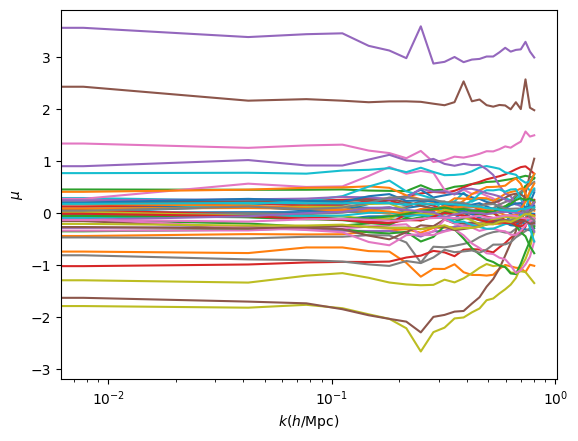

In [10]:

plt.plot(data.kf, mf_gp.q_mu.numpy().T);
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$\mu$")
plt.xscale("log")
plt.show()


In [11]:
# save model
mf_gp.save_model("mf_gp_singlebin.pkl")

✅ Model saved to mf_gp_singlebin.pkl


In [12]:
# 🔹 3️⃣ Define Multi-Fidelity GP Model
# ✅ Define base kernels for LF and HF discrepancy
kernel_L = gpflow.kernels.SquaredExponential(lengthscales=np.ones(5), variance=1.0)
kernel_delta = gpflow.kernels.SquaredExponential(lengthscales=np.ones(5), variance=1.0)

# ✅ Mixed Kernel (SE + Linear) to capture smooth & linear trends
kern_list = [gpflow.kernels.SquaredExponential() for _ in range(output_dim)]

# ✅ Optimize Inducing Points using K-Means Clustering
kmeans = KMeans(n_clusters=num_inducing, random_state=42).fit(X_train)
Z_init = kmeans.cluster_centers_


mf_gp_from_saved = SingleBinSVGP.load_model("mf_gp_singlebin.pkl", X_train, Y_train, kernel_L, kernel_delta, output_dim, Z_init)

🔹 KMeans Inducing Points: [[0.78 0.63 0.2  0.64 0.11 0.  ]
 [0.17 0.33 0.81 0.23 0.69 0.  ]
 [0.25 0.61 0.57 0.93 0.81 0.  ]
 [0.77 0.29 0.51 0.19 0.43 0.  ]
 [0.55 0.65 0.83 0.79 0.65 0.  ]
 [0.29 0.51 0.87 0.83 0.47 1.  ]
 [0.79 0.17 0.35 0.85 0.63 0.  ]
 [0.11 0.95 0.17 0.71 0.45 0.  ]
 [0.09 0.63 0.01 0.21 0.09 0.  ]
 [0.53 0.09 0.11 0.39 0.79 1.  ]
 [0.21 0.89 0.65 0.03 0.25 1.  ]
 [0.65 0.71 0.09 0.69 0.91 0.  ]
 [0.45 0.49 0.71 0.41 0.29 0.  ]
 [0.13 0.39 0.69 0.91 0.35 0.  ]
 [0.71 0.55 0.91 0.53 0.37 0.  ]
 [0.53 0.09 0.11 0.39 0.79 0.  ]
 [0.99 0.05 0.89 0.37 0.13 0.  ]
 [0.61 0.15 0.43 0.99 0.11 0.  ]
 [0.03 0.21 0.55 0.07 0.23 0.  ]
 [0.43 0.86 0.6  0.61 0.42 0.  ]
 [0.87 0.77 0.47 0.33 0.93 0.  ]
 [0.05 0.97 0.33 0.29 0.49 0.  ]
 [0.31 0.93 0.37 0.89 0.77 0.  ]
 [0.21 0.89 0.65 0.03 0.25 0.  ]
 [0.33 0.59 0.99 0.45 0.85 0.  ]
 [0.91 0.35 0.79 0.73 0.83 0.  ]
 [0.89 0.47 0.03 0.95 0.03 0.  ]
 [0.59 0.01 0.39 0.09 0.61 0.  ]
 [0.85 0.75 0.63 0.49 0.21 0.  ]
 [0.19 0.19 0.45 

In [13]:
# 🔹 5️⃣ Make Predictions on HF Test Set
X_test_HF_aug = np.hstack([X_test_HF, np.ones((10, 1))])  # Add HF indicator (1)
mean_pred, var_pred = mf_gp_from_saved.predict_f(X_test_HF_aug)

# 🔹 6️⃣ Compute Residuals
residuals = mean_pred.numpy() - Y_test_HF  # Shape: (10, 49)

# ✅ Print summary
print(f"🔍 Final Residuals: {residuals.mean():.4f} ± {residuals.std():.4f}")
print(f"✅ Model trained and predictions completed!")

# ✅ Check Noise Variance
print(f"🔍 Learned noise variance: {mf_gp_from_saved.likelihood.variance.numpy()}")

🔍 Final Residuals: -0.0005 ± 0.0041
✅ Model trained and predictions completed!
🔍 Learned noise variance: 8.566962931728014e-06


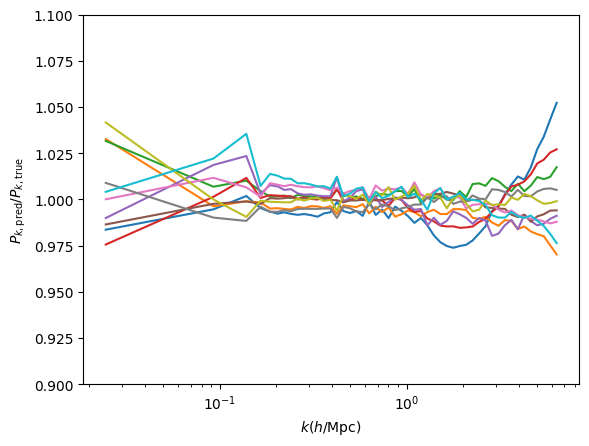

Text(0, 0.5, '$P_{k,\\mathrm{pred}}-P_{k,\\mathrm{true}}$')

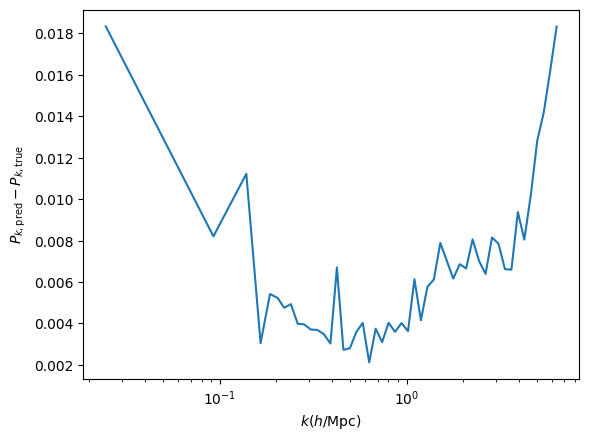

In [14]:
plt.semilogx(10**data.kf, (10**mean_pred/10**Y_test_HF).numpy().T);
plt.ylim(0.9, 1.1)
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}/P_{k,\mathrm{true}}$")
plt.show()
# absolute error
plt.semilogx(10**data.kf, np.abs((10**mean_pred/10**Y_test_HF - 1).numpy()).mean(axis=0));
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k,\mathrm{pred}}-P_{k,\mathrm{true}}$")